# BTC price prediction

In [457]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

In [458]:
data = pd.read_csv('BTC-USD.csv')

In [459]:
data.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-01,7194.892090,7254.330566,7174.944336,7200.174316,7200.174316,18565664997
1,2020-01-02,7202.551270,7212.155273,6935.270020,6985.470215,6985.470215,20802083465
2,2020-01-03,6984.428711,7413.715332,6914.996094,7344.884277,7344.884277,28111481032
3,2020-01-04,7345.375488,7427.385742,7309.514160,7410.656738,7410.656738,18444271275
4,2020-01-05,7410.451660,7544.497070,7400.535645,7411.317383,7411.317383,19725074095


### Preprocessing

In [460]:
year = []
month=[]
day=[]
for i in data['Date'].values:
    x = i.split('-')
    year.append(int(x[0]))
    month.append(int(x[1]))
    day.append(int(x[2]))
data['Year'] = year
data['Month'] = month
data['Day'] = day

In [461]:
data.sample(5)

,Date,Open,High,Low,Close,Adj Close,Volume,Year,Month,Day
378,2021-01-13,33915.121094,37599.960938,32584.667969,37316.359375,37316.359375,69364315979,2021,1,13
844,2022-04-24,39478.375000,39845.925781,39233.539063,39469.292969,39469.292969,17964398167,2022,4,24
1184,2023-03-30,28350.140625,29159.902344,27720.160156,28033.562500,28033.562500,22435349951,2023,3,30
423,2021-02-27,46344.773438,48253.269531,45269.027344,46188.453125,46188.453125,45910946382,2021,2,27
649,2021-10-11,54734.125000,57793.039063,54519.765625,57484.789063,57484.789063,42637331698,2021,10,11


In [462]:
data['Date']=pd.to_datetime(data['Date'])

In [463]:
# prev_score give us the difference between the highest price and the lowest price
data['Prev_close'] = data['Close'].shift(1)
data.dropna(axis=0,inplace=True)
# delta_hl give us the difference between the highest and the actual close
data['delta_hl'] = data['High'] - data['Low']

In [464]:
train = data[data['Date'] <= pd.datetime(2022,12,31,23,59)]
test = data[data['Date'] >= pd.datetime(2022,12,31,23,59)]

C:\Users\DELL\AppData\Local\Temp\ipykernel_14532\1666691955.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  train = data[data['Date'] <= pd.datetime(2022,12,31,23,59)]
C:\Users\DELL\AppData\Local\Temp\ipykernel_14532\1666691955.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  test = data[data['Date'] >= pd.datetime(2022,12,31,23,59)]


### Data visualisation

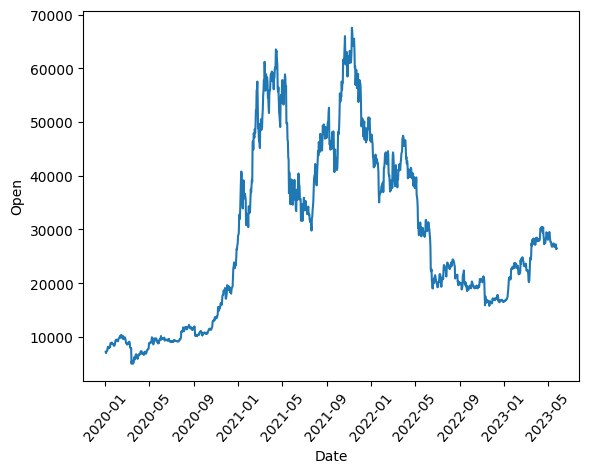

In [465]:
sns.lineplot(data,x='Date',y='Open')
plt.xticks(rotation = 50)
plt.show()      

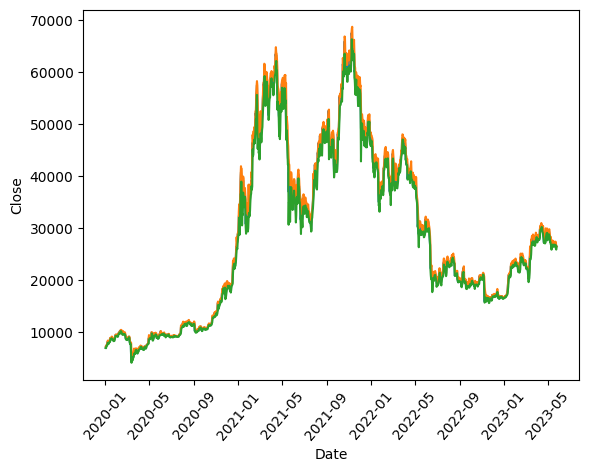

In [466]:
sns.lineplot(data,x='Date',y='Close')
sns.lineplot(data,x='Date',y='High')
sns.lineplot(data,x='Date',y='Low')
plt.xticks(rotation = 50)
plt.show()      

In [467]:
true_test = test['Close']

In [468]:
train.drop('Date',axis=1,inplace=True)
test.drop('Date',axis=1,inplace=True)

C:\Users\DELL\AppData\Local\Temp\ipykernel_14532\565370736.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.drop('Date',axis=1,inplace=True)
C:\Users\DELL\AppData\Local\Temp\ipykernel_14532\565370736.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop('Date',axis=1,inplace=True)


### Model

In [469]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn import metrics

In [497]:
y=train['Close']
x=train.drop('Close',axis=1,inplace=False)
train_X, test_X, train_y, test_y = train_test_split(x, y,test_size = 0.3, random_state = 40)
xgb_r = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators = 10, seed = 123)
xgb_r.fit(train_X, train_y)
pred = xgb_r.predict(test_X)
rmse = np.sqrt(MSE(test_y, pred))
print("RMSE : % f" %(rmse))
print("R squared: ", metrics.r2_score(test_y,pred))

RMSE :  1129.951705
R squared:  0.9958650917395325


In [486]:
tst = test.drop('Close',axis=1,inplace=False)
tst=tst.to_numpy()

In [487]:
pred=xgb_r.predict(tst)
rmse = np.sqrt(MSE(true_test, pred))
print("RMSE : % f" %(rmse))
print("R squared: ", metrics.r2_score(true_test,pred)) 

RMSE :  1017.696200
R squared:  0.9209157977706959


### Hyperparameter tuning

In [498]:
def accuracy(k):    
    train_X, test_X, train_y, test_y = train_test_split(x, y,test_size = 0.3, random_state = k)
    xgb_r = xgb.XGBRegressor(objective ='reg:tweedie',n_estimators = 40, seed = 0)
    xgb_r.fit(train_X, train_y)
    pred = xgb_r.predict(test_X)
    rmse = np.sqrt(MSE(test_y, pred))
    return rmse
def best_rd(x):
    d=[]
    for i in range(0,x+1):
        d.append(accuracy(i))
    return d
c =best_rd(200)
m=c.index(min(c))
m

101

In [500]:
def accuracy(k):    
    train_X, test_X, train_y, test_y = train_test_split(x, y,test_size = 0.3, random_state = 101)
    xgb_r = xgb.XGBRegressor(objective ='reg:tweedie',n_estimators = k, seed = 0)
    xgb_r.fit(train_X, train_y)
    pred = xgb_r.predict(test_X)
    rmse = np.sqrt(MSE(test_y, pred))
    return rmse
def best_rd(x):
    d=[]
    for i in range(0,x+1):
        d.append(accuracy(i))
    return d
c =best_rd(100)
m=c.index(min(c))
m

48

In [477]:
def accuracy(k):    
    train_X, test_X, train_y, test_y = train_test_split(x, y,test_size = 0.3, random_state = 123)
    xgb_r = xgb.XGBRegressor(objective ='reg:tweedie',n_estimators = 80, seed = k)
    xgb_r.fit(train_X, train_y)
    pred = xgb_r.predict(test_X)
    rmse = np.sqrt(MSE(test_y, pred))
    return rmse
def best_rd(x):
    d=[]
    for i in range(0,x+1):
        d.append(accuracy(i))
    return d
c =best_rd(200)
m=c.index(min(c))
m

0

### Score and Evaluation

In [490]:
y=train['Close']
x=train.drop('Close',axis=1,inplace=False)
train_X, test_X, train_y, test_y = train_test_split(x, y,test_size = 0.3, random_state = 101)
xgb_r = xgb.XGBRegressor(objective ='reg:tweedie',n_estimators = 48, seed = 0)
xgb_r.fit(train_X, train_y)
pred = xgb_r.predict(test_X)
rmse = np.sqrt(MSE(test_y, pred))
print("RMSE : % f" %(rmse))
print("R squared: ", metrics.r2_score(test_y,pred))

RMSE :  100.990301
R squared:  0.9999659090178227


In [491]:
pred=xgb_r.predict(tst)
rmse = np.sqrt(MSE(true_test, pred))
print("RMSE : % f" %(rmse))
print("R squared: ", metrics.r2_score(true_test,pred)) 

RMSE :  353.137071
R squared:  0.9904777396170783


In [492]:
comparaison = pd.DataFrame()
x = true_test.values

In [493]:
comparaison['Predictions'] = pred
comparaison['True_test'] = x

In [494]:
comparaison

,Predictions,True_test
0,16621.486328,16625.080078
1,16647.105469,16688.470703
2,16636.203125,16679.857422
3,16854.005859,16863.238281
4,16852.238281,16836.736328
...,...,...
141,26309.685547,26851.277344
142,27074.392578,27225.726563
143,26704.996094,26334.818359
144,26317.589844,26476.207031


<Axes: xlabel='Predictions', ylabel='True_test'>

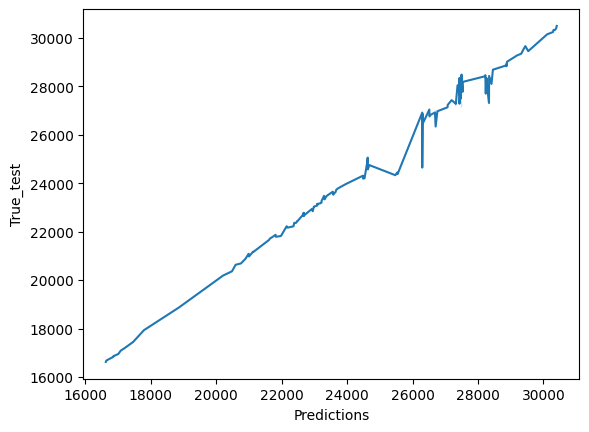

In [495]:
sns.lineplot(comparaison,x='Predictions',y='True_test')

In [501]:
import pickle
with open('btc_regressor','wb') as f:
    pickle.dump(xgb_r,f)